In [79]:
import pandas as pd
import numpy as np

#Graphiques
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.graph_objects as gp


#Statistiques
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.cluster import KMeans
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [65]:
input_path = "./01_Input_Data"
output_path = "./2_outputs"

importation des données

In [66]:
path =input_path + '/bank-additional-full.csv'
data_set = pd.read_csv(path,sep=";",decimal=",")

In [67]:
# Vérifier si des valeurs NaN sont présentes
if data_set.isnull().values.any():
    print("Le dataset contient des valeurs NaN.")
else:
    print("Le dataset ne contient pas de valeurs NaN.")

# Pour voir combien de NaN par colonne
print("Nombre de NaN par colonne :")
# print(data_set.isnull().sum())

Le dataset ne contient pas de valeurs NaN.
Nombre de NaN par colonne :


In [68]:
data_set.head()
# data_set.info()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [69]:
# Synthèse des variables 
# data_set.describe(include="all")

In [70]:


def classifier_variables(data_set):
    # Initialisation des listes
    variables_na = []
    variables_numeriques = []
    variables_01 = []
    variables_categorielles = []

    # Parcourir les colonnes du dataset
    for colu in data_set.columns:
        # Vérifier si la colonne contient des valeurs NaN
        if data_set[colu].isna().any():
            variables_na.append(colu)
        else:
            # Vérifier si la colonne est de type numérique
            if data_set[colu].dtype in ["int32", "int64", "float32", "float64"]:
                # Vérifier si la colonne est binaire (deux valeurs uniques)
                if len(data_set[colu].unique()) == 2:
                    variables_01.append(colu)
                else:
                    variables_numeriques.append(colu)
            else:
                # Gérer les colonnes non numériques
                if len(data_set[colu].unique()) == 2:
                    variables_01.append(colu)
                else:
                    variables_categorielles.append(colu)

    # Création du dictionnaire des résultats
    resultat = {
        "variables_na": variables_na,
        "variables_numeriques": variables_numeriques,
        "variables_binaires": variables_01,
        "variables_categorielles": variables_categorielles
    }

    return resultat

# Exemple d'utilisation
variables= classifier_variables(data_set)
print(variables)


{'variables_na': [], 'variables_numeriques': ['age', 'duration', 'campaign', 'pdays', 'previous'], 'variables_binaires': ['contact', 'y'], 'variables_categorielles': ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']}


In [71]:
# Compter le nombre de fois où "UNKNOWN" apparaît par colonne
unknown_counts = (data_set == "unknown").sum()

# Afficher uniquement les colonnes où "UNKNOWN" est présent
unknown_counts = unknown_counts[unknown_counts > 0]

print("Nombre de modalités 'UNKNOWN' par colonne :")
print(unknown_counts)


Nombre de modalités 'UNKNOWN' par colonne :
job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64


In [72]:
# Compter le nombre de fois où "nonexistent" apparaît par colonne
nonexistent_counts = (data_set == "nonexistent").sum()

# Afficher uniquement les colonnes où "nonexistent" est présent
nonexistent_counts = nonexistent_counts[nonexistent_counts > 0]

print("Nombre de modalités 'nonexistent' par colonne :")
print(nonexistent_counts)


Nombre de modalités 'nonexistent' par colonne :
poutcome    35563
dtype: int64


In [73]:
import pandas as pd
import numpy as np

# Remplacer les valeurs "UNKNOWN" par NaN
data_set.replace("unknown", np.nan, inplace=True)

# Calculer le nombre de NaN par variable
nan_count = pd.DataFrame(data_set.isna().sum(), columns=["Nombre_NA"])

# Ajouter le pourcentage de valeurs NaN par rapport au total des lignes
nan_count["Pourcentage"] = (nan_count["Nombre_NA"] / data_set.shape[0]) * 100

# print(nan_count)


In [74]:
# data_set.set_index('y', inplace=True)
# data_set.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
# data_set.plot()
# data_set.plot.box()
# axs = data_set.plot.area(figsize=(20, 20), subplots=True)

import matplotlib.pyplot as plt

def plot_categorical_histograms(data_set, variable_dict):
    """
    Trace un histogramme pour chaque variable catégorielle dans le DataFrame.

    :param data_set: DataFrame contenant les données.
    :param variable_dict: Dictionnaire des variables classées, issu de classifier_variables.
    """
    # Extraire les variables catégorielles du dictionnaire
    variables_categorielles = variable_dict.get("variables_categorielles", [])
    variables_categorielles += variable_dict.get("variables_binaires", [])

    # Vérifier s'il y a des variables catégorielles
    if not variables_categorielles:
        print("Aucune variable catégorielle à tracer.")
        return

    # Tracer un histogramme pour chaque variable catégorielle
    for var in variables_categorielles:
        plt.figure(figsize=(8, 5))
        data_set[var].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f"Distribution de la variable '{var}'")
        plt.xlabel(var)
        plt.ylabel("Fréquence")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
# data_set est votre DataFrame
# resultat est le dictionnaire renvoyé par classifier_variables


# plot_categorical_histograms(data_set, variables)




In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_scatter_sns(data_set, variable_dict, target):
    """
    Trace un graphique pour chaque variable catégorielle dans le DataFrame, utilisant uniquement Seaborn.

    :param data_set: DataFrame contenant les données.
    :param variable_dict: Dictionnaire des variables classées, issu de classifier_variables.
    :param target: Nom de la colonne cible (variable dépendante).
    """
    # Extraire les variables catégorielles et binaires du dictionnaire
    variables_categorielles = variable_dict.get("variables_categorielles", [])

    # Vérifier s'il y a des variables catégorielles ou binaires
    if not variables_categorielles:
        print("Aucune variable catégorielle ou binaire à tracer.")
        return

    # Tracer les graphiques pour chaque variable catégorielle/binaire
    for var in variables_categorielles:
        plt.figure(figsize=(10, 6))
        contingency_table = pd.crosstab(data_set[target], data_set[var])
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
        plt.title(f"Relation entre '{var}' et '{target}'", fontsize=16, fontweight='bold')
        plt.xlabel(var, fontsize=12)
        plt.ylabel(target, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
# data_set est votre DataFrame
# variable_dict est le dictionnaire renvoyé par classifier_variables



# plot_categorical_scatter_sns(data_set, variables, 'y')


traitement du data set

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188,41188,41188,41188,41188,41188
unique,NaN,11,3,7,2,2,2,2,10,5,NaN,NaN,NaN,NaN,3,10,26,26,316,11
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,NaN,NaN,NaN,NaN,nonexistent,1.4,93.994,-36.4,4.857,5228.1
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,NaN,NaN,NaN,NaN,35563,16234,7763,7763,2868,16234
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.285010,2.567593,962.475454,0.172963,NaN,NaN,NaN,NaN,NaN,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.279249,2.770014,186.910907,0.494901,NaN,NaN,NaN,NaN,NaN,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.000000,1.000000,999.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,2.000000,999.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.000000,3.000000,999.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


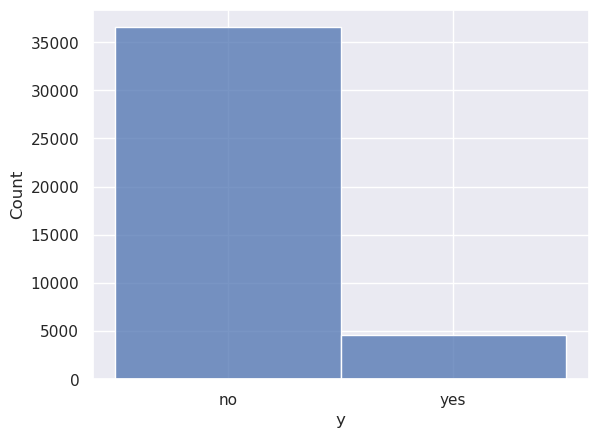

In [76]:
# separation de la cible et des variables explicatives
target=data_set['y']
data_model=data_set.drop(columns=['y'])
# histogramme de la cible
_=sns.histplot(target)
data_model.describe(include='all')

Etude des correlations entre les variables explicatives

In [77]:
variables= classifier_variables(data_model)

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))


def correlation(data,type='categorielles'):
    # # Variables numériques
    # variables_numeriques = variables["variables_numeriques"]
    # # Calcul de la matrice de corrélation
    # corr_matrix = data_set[variables_numeriques].corr()
    # # Tracer la matrice de corrélation
    # plt.figure(figsize=(12, 8))
    # sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    # plt.title("Matrice de corrélation entre les variables numériques", fontsize=16, fontweight='bold')
    # plt.xticks(rotation=45, fontsize=10)
    # plt.yticks(fontsize=10)
    # plt.tight_layout()
    # plt.show()
    
    # Variables categorielles
    vars = variables["variables_categorielles"]
    if type=='categorielles':
        # # Calcul de la matrice de corrélation
        # corr_matrix = data_model[variables_categorielles].corr()
        # # Tracer la matrice de corrélation
        # plt.figure(figsize=(12, 8))
        # sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        # plt.title("Matrice de corrélation entre les variables catégorielles", fontsize=16, fontweight='bold')
        # plt.xticks(rotation=45, fontsize=10)
        # plt.yticks(fontsize=10)
        # plt.tight_layout()
        # plt.show()
        
        # Test du V de Cramer
        rows= []

        for var1 in vars:
          col = []
          for var2 in vars_categorielles :
            cramers =cramers_V(vars_categorielles[var1], vars_categorielles[var2]) # V de Cramer
            col.append(round(cramers,2)) # arrondi du résultat   
          rows.append(col)

        cramers_results = np.array(rows)
        v_cramer_resultats = pd.DataFrame(cramers_results, columns = vars_categorielles.columns, 
                                          index =vars_categorielles.columns)

        v_cramer_resultats
    

print(variables["variables_categorielles"])

['month', 'day_of_week', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [2]:
# variables= classifier_variables(data_model)

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))


def correlation(data):
    
    # Variables
    variables = classifier_variables(data)
    
    data_categorielles = data_model[variables['variables_categorielles']]
    # Test du V de Cramer
    rows= []
    for var1 in data_categorielles:
      col = []
      for var2 in data_categorielles :
        cramers =cramers_V(data_categorielles[var1], data_categorielles[var2]) # V de Cramer
        col.append(round(cramers,2)) # arrondi du résultat   
      rows.append(col)

      cramers_results = np.array(rows)
      v_cramer_resultats = pd.DataFrame(cramers_results, columns = data_categorielles.columns, 
                                          index =data_categorielles.columns)

    return (v_cramer_resultats)
    

# print(variables["variables_categorielles"])

# data_categorielles = data_model[variables['variables_categorielles']]
# data_categorielles.head()

v_cramer_resultats = correlation(data_model)


NameError: name 'data_model' is not defined

In [ ]:

# Analyse exploratoire des données
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des variables numériques
data_set.hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Heatmap des corrélations
plt.figure(figsize=(15, 10))
sns.heatmap(data_set.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Corrélations entre variables numériques')
plt.show()


In [ ]:

# Encodage des variables catégoriques
data_set = pd.get_dummies(data_set, drop_first=True)

# Normalisation des variables numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
data_set[numerical_cols] = scaler.fit_transform(data_set[numerical_cols])


In [ ]:

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

# Séparer les données en X (caractéristiques) et y (cible)
X = data_set.drop('y_yes', axis=1)  # La variable cible encodée en y_yes
y = data_set['y_yes']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modèle Random Forest avec validation croisée
model = RandomForestClassifier(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

print("Scores de validation croisée AUC : ", cv_scores)
print("Moyenne des scores : ", cv_scores.mean())

# Entraînement et évaluation du modèle
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Courbe ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()
